** Assignment 6B**
=================
Name : Nihar Kanungo Batch : 6:30 AM , Monday

Background :
==========
This is a Image Recognition program which makes use of the Cifar 10 preprocessed dataset . The Code uses one of the most popular Tensorflow API Keras to perform the operations .It's a supervised Computer Vision problem.

This is the first program in the series of programs using Function API . In this program we will be using 

1. Normal Convolution 
2. Spatially Separable Convolution  (Conv2d(x, (3,1)) followed by Conv2D(x,(1, 3))
3. Depthwise Separable Convolution
4. Grouped Convolution (3x3 and 5x5)
5. Grouped Convolution (3x3 only, one with dilation = 1, and another with dilation = 2) 

Input
=======

1) 60000 images (10 Class)

2) The Images are already segreegated as Train and Test Data with the respective target values

Environment

Development - Colab GPU , Jupyter Notebook Repository : Github

Algorithm
===========
Functional API Model 

Convolutional Neural Network (2D)

Maxpooling 

Softmax Activation function 

loss Function : Categorical Crossentropy 

Optimizer=Adam, SGD 

Metrics=accuracy 

Batch Normalization 

Drop Out 

Image Normalization 

L2 Regularization

Parameters
===========

Batch Size - Variable 

Epochs - Variable 

Kernel Size - Variable 

Number of Kernels - Variable 

Learning Rate regularization coefficient

Conditions
==========
The Model should train (> 20% accuracy ). As this program is meant to show the usage of functional API and not to accurately predict the classes .

# Import all Libraries 

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, DepthwiseConv2D, Conv2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Input, concatenate
from keras.layers.pooling import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Nadam, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import l2
%config InlineBackend.figure_format='retina'
from keras.models import Model


* Load the CIFAR 10 images into the notebook 
===========================================

The **CIFAR-10 dataset** (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. 
Computer algorithms for recognizing objects in photos often learn by example. CIFAR-10 is a set of images that can be used to teach a computer how to recognize objects. Since the images in CIFAR-10 are low-resolution (32x32), this dataset can allow researchers to quickly try different algorithms to see what works. Various kinds of convolutional neural networks tend to be the best at recognizing the images in CIFAR-10.
CIFAR-10 is a labeled subset of the 80 million tiny images dataset. When the dataset was created, students were paid to label all of the images. 

Source : wikipedia

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

Display the Class outputs
===========================

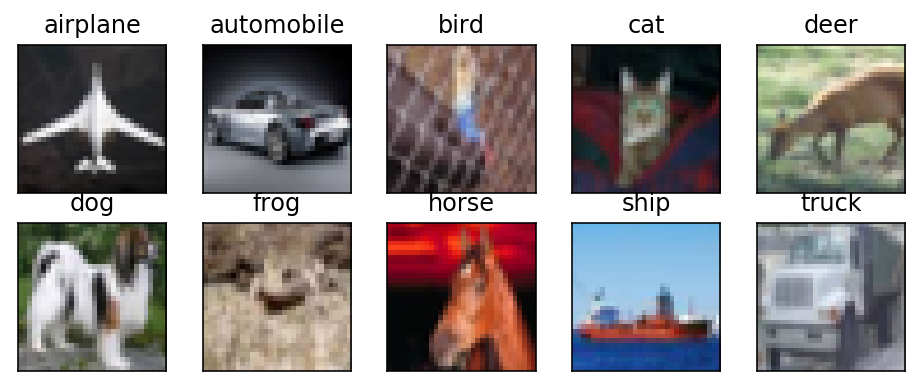

In [10]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

Function to define the Model history and Plot chart
=====================================================
The Parameters of the model is a key information to quickly visualize how the model performed . Analysis of the

1. Training Accuracy vs Validation Accuracy and

2. Training Loss vs Validation Loss

would give a great understanding of the model performance

Writting a custom function helps us to modify or customize the information based on our need. We are building these functions so that we can customize more in future

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

# Function to define the Accuracy of the model

This custom function will help us i future to design the Accuracy based on our need

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

Standardize the data by diving it by 255
==========================================

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

Each of the above discussed convolution methods has been designed as functions below . We may use multiple such layers in our network.


Normal convolution
===================

This convolution is the one which we have been doing so far

![](images/nc.png)

In [0]:

def norm_conv_layer(inputs, n_kernels=32, kernel_size=(3,3), dropout=0.1,dilation_rate=1, border_mode='valid',stride=1):
  conv_out = Conv2D(n_kernels,
                kernel_size=kernel_size,
                strides=stride,
                border_mode=border_mode,
                kernel_regularizer=l2(1e-4),
                dilation_rate=dilation_rate)(inputs)
  conv_out = BatchNormalization()(conv_out)
  conv_out = Activation("relu")(conv_out)
  conv_out = Dropout(dropout)(conv_out)
  return conv_out







Depthwise Separable Convolution
=======================

Depthwise convolution deals with number of channels .Every channel will have different interpretations . Fir example if a layer of the network has 64 channels then there would be 64 different interpretation for it . All these can work in parallel. The diagram below explains it.

![](images/ds.png)

In [0]:
def depthwise_conv_layer(inputs, n_kernels=32, kernel_size=(3,3),dropout=0.1,dilation_rate=1, border_mode='valid', depth_multiplier=1,):
  dep_conv_out = SeparableConv2D(n_kernels,
                kernel_size=kernel_size,
                strides=1,
                border_mode=border_mode,
                kernel_regularizer=l2(1e-4),
                dilation_rate=dilation_rate,
                depth_multiplier=depth_multiplier,)(inputs)
  dep_conv_out = BatchNormalization()(dep_conv_out)
  dep_conv_out = Activation("relu")(dep_conv_out)
  dep_conv_out = Dropout(dropout)(dep_conv_out)
  return dep_conv_out

Spatially Separable Convolution
================================

Spatially separable convolution works on the principle of diving a m x n kernel by m x 1 followed by 1 x n on the same image . The image below shows how it visually looks 

![](images/ss.png)

In [0]:
def sep_conv_layer(inputs, n_kernels=32, kernel_size=(3,3),dropout=0.1,dilation_rate=1, border_mode='same'):
  # We use kernel_size[0]x1 and then 1xkernel_size[1] conv
  
  sep_conv_out = Conv2D(n_kernels,
                kernel_size=(kernel_size[0],1),
                border_mode=border_mode,
                kernel_regularizer=l2(1e-4),
                dilation_rate=dilation_rate,
                strides=dilation_rate, # to achive right dilation with separable we need to use strides.
                )(inputs)
  sep_conv_out = Conv2D(n_kernels,
                kernel_size=(1,kernel_size[1]),
                border_mode=border_mode,
                kernel_regularizer=l2(1e-4),
                dilation_rate=dilation_rate,
                strides=dilation_rate, # to achive right dilation with separable we need to use strides.
                )(sep_conv_out)
  sep_conv_out = BatchNormalization()(sep_conv_out)
  sep_conv_out = Activation("relu")(sep_conv_out)
  sep_conv_out = Dropout(dropout)(sep_conv_out)
  return sep_conv_out

Grouped Convolution
======================
Group convolution is the concept in which one image is being convolved by many different size kernels to generate multiple receptive fields of the image of different size . This comes handy when we try to detect objects of different size in an image. A high level architecture diagram is shown below

![](images/gc.png)

In [0]:
def grouped_conv_layer(inputs, group_configs, out_channels):
  groups = []
  for group_config in group_configs:
    group_out = inputs
    for layer_config in group_config:
      group_out = norm_conv_layer(group_out, **layer_config)
    groups.append(group_out)
  y = concatenate(groups)
  y = trans_layer(y, out_channels)
  return y


Transition Layer
==================

1 x 1 convolution 

In [0]:
def trans_layer(inputs, n_kernels=32,dropout=0):
  trans_out = norm_conv_layer(inputs, n_kernels, kernel_size=(1,1),dropout=dropout, border_mode='same')
  return trans_out


# Output function 

1. Flatten

2. Softmax layer

In [0]:
def output_layer(inputs, n_classes, kernel_size):
  final_out = Conv2D(n_classes,
                kernel_size=kernel_size,
                strides=1,
                border_mode='valid',
                kernel_regularizer=l2(1e-4),
                dilation_rate=1)(inputs)
  final_out = Flatten()(final_out)
  out = Activation("softmax")(final_out)
  return out

#Functional API model

Model Architecture 
=====================


**Normal Convolution Layer**


      32 kernels of size 3 x 3
      dropout of 0.1
      dilation rate of 1

**Normal Convolution Layer**


      64 kernels of size 3 x 3
      dropout of 0.1
      dilation rate of 1
      Border Mode same 

**Spatially Separable Convolution Layer**

      64 kernels of size 3 x 3 ( 3 x 1 followed by 1 x 3)
      dropout of 0.1
      dilation rate of 1
      
**Depthwise Separable Convolution Layer**

      128 kernels of size 3 x 3 
      dropout of 0.1
      dilation rate of 1
      
**Maxpooling Layer**

      
      2 x 2 
      
**Transition Layer**

      32 kernels of size 1 x 1
      dropout of 0.1
      
**Grouped Convolution Layer**

      16 kernels of size 3 x 3 and 5 x 5 each
      dropout of 0.1
      dilation rate of 1
      
      
**Grouped Convolution Layer**

      8 kernels of size 1 x 1 
      8 kernels of size  3 x 3 with dilation rate of 1
      16 kernels of size 3 x 3 with dilation rate of 2
      
**Maxpooling Layer**

      
      2 x 2 
      
      
**Normal Convolution Layer**


      64 kernels of size 3 x 3
      
      
**Transition Layer**

      32 kernels of size 1 x 1
       
      
      
**Output Layer**

      10 kernels of size 5 x 5 to generate output class 
     
      


In [53]:
inputs = Input(shape=(32,32,3))
x = norm_conv_layer(inputs,n_kernels=32,kernel_size=(3,3),border_mode='valid') # 3
x = norm_conv_layer(x,n_kernels=32,kernel_size=(3,3),border_mode='same') # 5
x = sep_conv_layer(x, n_kernels=64,kernel_size=(3,3),border_mode='valid') #  7
x = depthwise_conv_layer(x, n_kernels=128,kernel_size=(3,3),border_mode='valid') #  9
x = MaxPooling2D(pool_size=(2, 2))(x) # 18
x = trans_layer(x, n_kernels=32,dropout=0) #  18


gx = grouped_conv_layer(x, group_configs=[[dict(n_kernels=16, kernel_size=(3,3), dropout=0.1,dilation_rate=1, border_mode='same')],
                                    [dict(n_kernels=16, kernel_size=(5,5), dropout=0.1,dilation_rate=1, border_mode='same')]],
                                    out_channels = 16) # 20,22

gx = grouped_conv_layer(x, group_configs=[[dict(n_kernels=8, kernel_size=(1,1), dropout=0.1,dilation_rate=1, border_mode='same')],
                                    [dict(n_kernels=8, kernel_size=(3,3), dropout=0.1,dilation_rate=1, border_mode='same')],
                                    [dict(n_kernels=16, kernel_size=(3,3), dropout=0.1,dilation_rate=2, border_mode='same')]],
                                    out_channels = 16) # 20,22,24,26





x = concatenate([x, gx])


x = MaxPooling2D(pool_size=(2, 2),border_mode='same')(x) # 36, 40, 44, 48, 52



x = norm_conv_layer(x, n_kernels=64,kernel_size=(3,3),border_mode='valid') # 38, 42, 46, 50, 54
x = trans_layer(x, n_kernels=32,dropout=0)

output = output_layer(x, n_classes=10, kernel_size=(5,5)) # 42, 46, 50, 54, 58


model = Model(inputs=inputs, outputs=output)

optimizer = SGD(lr=0.001)


model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, kernel_size=(3, 3), strides=1, kernel_regularizer=<keras.reg..., dilation_rate=1, padding="valid")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, kernel_size=(3, 3), strides=1, kernel_regularizer=<keras.reg..., dilation_rate=1, padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, kernel_size=(3, 1), kernel_regularizer=<keras.reg..., dilation_rate=1, strides=1, padding="valid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, kernel_size=(1, 3), kernel_regularizer=<keras.reg..., dilation_rate=1, strides=1, padding="valid")`
/usr/local/lib/python3.6/dist-pac

(None, 13, 13, 48)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, kernel_size=(3, 3), strides=1, kernel_regularizer=<keras.reg..., dilation_rate=1, padding="valid")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, kernel_size=(5, 5), strides=1, kernel_regularizer=<keras.reg..., dilation_rate=1, padding="valid")`


# Print the summary of the model architecture 

In [54]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_179 (Conv2D)             (None, 30, 30, 32)   896         input_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_171 (BatchN (None, 30, 30, 32)   128         conv2d_179[0][0]                 
__________________________________________________________________________________________________
activation_180 (Activation)     (None, 30, 30, 32)   0           batch_normalization_171[0][0]    
__________________________________________________________________________________________________
dropout_17

# Model Training and Validation

1. Normalize the Images

2. Fit the images to the model

3. Calculate the time taken for training 

4. Plot the model parameters

5. Print the last validation accuracy


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 56s 145ms/step - loss: 2.3656 - acc: 0.1640 - val_loss: 2.1790 - val_acc: 0.2027
Epoch 2/50
390/390 [==============================] - 43s 110ms/step - loss: 2.0856 - acc: 0.2477 - val_loss: 2.0327 - val_acc: 0.2468
Epoch 3/50
390/390 [==============================] - 43s 110ms/step - loss: 1.9322 - acc: 0.3032 - val_loss: 1.9470 - val_acc: 0.2724
Epoch 4/50
390/390 [==============================] - 43s 110ms/step - loss: 1.8198 - acc: 0.3433 - val_loss: 1.8510 - val_acc: 0.3056
Epoch 5/50
390/390 [==============================] - 43s 110ms/step - loss: 1.7329 - acc: 0.3747 - val_loss: 1.8362 - val_acc: 0.3211
Epoch 6/50
390/390 [==============================] - 43s 110ms/step - loss: 1.6736 - acc: 0.3926 - val_loss: 1.7611 - val_acc: 0.3447
Epoch 7/50
390/390 [==============================] - 43s 110ms/step - loss: 1.6266 - acc: 0.4114 - val_loss: 1.6793 - val_acc: 0.3734
Epoch 8/50
390/390 [==============================] - 4

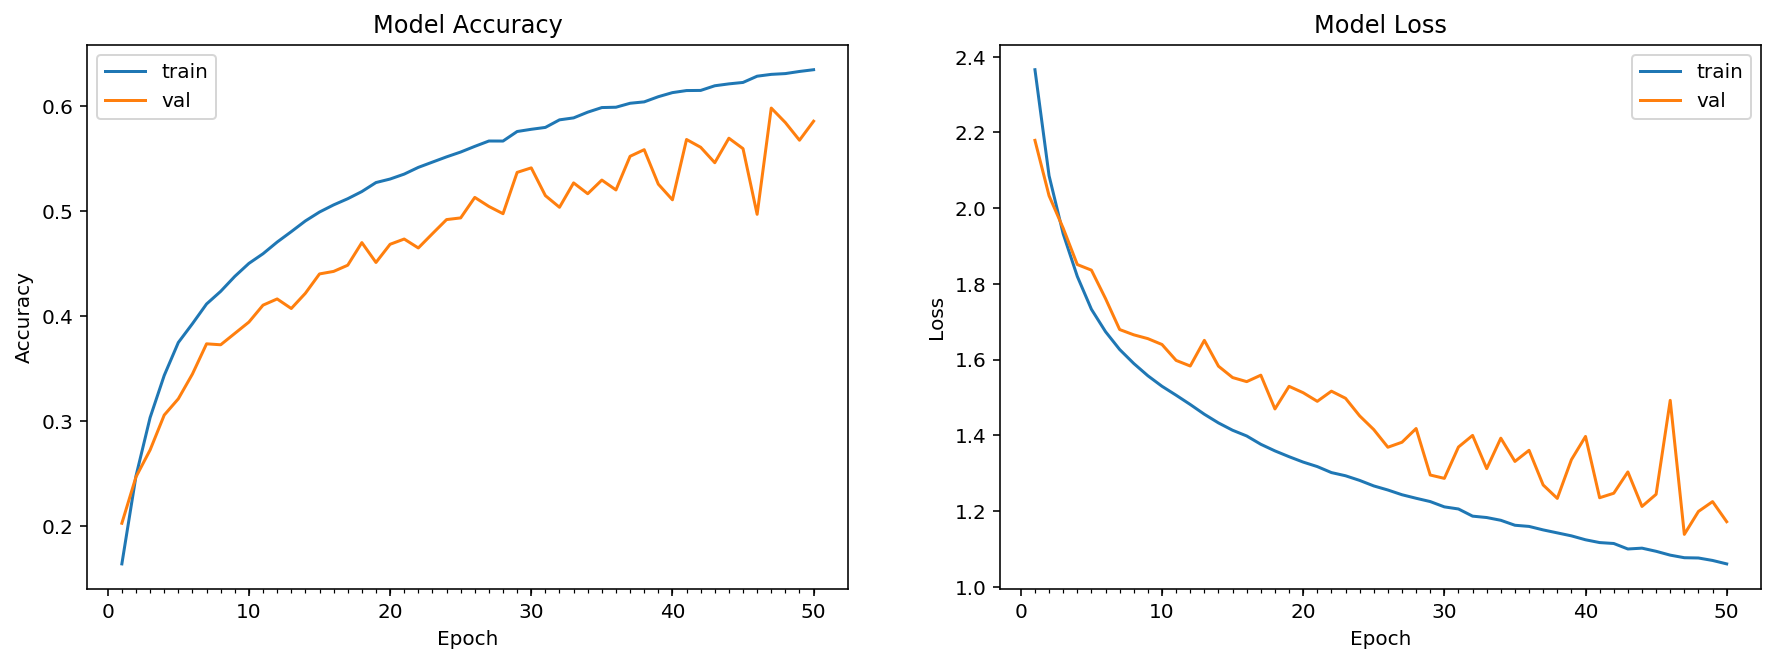

Accuracy on test data is: 58.52


In [55]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Summary
========

The model trained with a validation accuracy of around 58.52%. The model graphs shows a lot of spike. One of the possible reason could be the optimization problem. 

This program is to demonstarte different type of convolution functions . We will work much more on the functional API's in future and work towards making a perfect fit model.

**********   End of Program *************